# LAB: Workflow de Datos. Limpieza y sumarización de datos para el Desafío 3.

## Introducción

La idea de este lab es comenzar a trabajar con los datos del Desafío 3. Vamos a tratar de comenzar con el proceso de limpieza, sumarización y análisis exploratorio del dataset de Properatti. Como recordarán, el objetivo final es el desarrollo de un tasador automático a ser aplicado a las próximas propiedades que sean comercializadas por la empresa mediante un modelo de regresión. Como verán, el dataset está sumamente "sucio" y require un intenso proceos de limpieza.

El dataset contiene información referida al primer semestre de 2017 de las propiedades comercializables por la empresa:

* Fecha de creación
* Tipo de la propiedad (house, apartment, ph)
* Operación del aviso (sell, rent)
* Nombre del lugar
* Nombre del lugar + nombre de sus ‘padres’
* ID de geonames del lugar (si está disponible)
* Latitud,Longitud
* Precio original del aviso
* Moneda original del aviso (ARS, USD)
* Precio del aviso en moneda local (ARS)
* Precio aproximado en USD
* Superficie en m²
* Superficie cubierta en m²
* Precio en USD/m²
* Precio por m²
* N° de piso, si corresponde
* Ambientes
* URL en Properati
* Descripción
* Título
* URL de un thumbnail de la primer foto


Una vez terminada la limpieza, aquellos que se animen pueden empezar a probar algunos modelos simples de regresión.


## Objetivos de aprendizaje

* Practicar técnicas de limpieza de datos de tipo texto
* Practicar conversiones de tipo de dato
* Practicar rellenar datos faltantes con 0s o promedios
* Practicar técnicas para trabajo con datos categóricos
* Transformar datos a información útil
* Realizar un primer análisis exploratorio
* BONUS: realizar un primer modelo de regresión

In [33]:
% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import re
import seaborn as sns

In [2]:
# Cargar la data
df = pd.read_csv('properatti.csv')  # DATOS DE PROPIEDADES EN VENTA PROPERATI

# Limpiar el dataset
Practiquemos nuestras capacidades para realizar limpieza de datos con el dataset de ventas de propiedades de Properatti. Si no recuerdan cómo hacer alguna de estas tareas, busquen en Internet o en clases anteriores de manipulación de datos.

Buscamos que completen las siguientes tareas:
* Quitar columnas redundantes
* Convertir las variables categóricas numéricas a integer
* Lidiar con los valores perdidos y/o erróneos en algunas variables clave: 

    + en este punto podría ser interesante realizar algo ligeramente más complejo que un simple rellenado en función de medias. Podría eventualmente imputar en función de medias condicionadas.
        * por ejemplo, los campos `lat` y `long` tienen, también, muchos casos perdidos. Quizás una estrategia posible sería tratar de imputar las coordenadas con la media de los casos en el mismo `place_name` -barrio-.
    + también podrían evaluar la posibilidad de extraer alguna información para completar los datos perdidos del campo "description" que contiene texto del aviso. 
        * por ejemplo, el campo `rooms` tiene una altísima cantidad de missing. Podrían intentar usando alguna expresión regex extraer información 

In [4]:
#Analizamos las columnas, los tipos de datos y la cantidad de datos nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

# Filtrar los Datos

En general, los mdoelos de precios suelen tener un carácter local. Es por eso que deberán elegir alguna zona o provincia para trabajar y estimar el modelo en base a dicha selección.

In [10]:
#Validamos que no tengamos duplicados
df.drop_duplicates(subset=['lat-lon','properati_url','description']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

In [11]:
def obtener_superficie(x):
    if ~np.isnan(x['surface_covered_in_m2']):
        return x['surface_covered_in_m2']
    elif ~np.isnan(x['surface_total_in_m2']):
        return x['surface_total_in_m2']
    else:
        return np.nan

In [12]:
def calcular_precio(x):
    if ~np.isnan(x['price_aprox_usd']):
        return x['price_aprox_usd']
    elif ~np.isnan(x['price_per_m2'])  :
        return x['price_per_m2'] * df['superficie_cubierta']
    elif ~np.isnan(x['price_usd_per_m2']): 
        return x['price_usd_per_m2'] * df['superficie_cubierta']
    else:
        return np.nan

In [13]:
def obtener_ambientes(x):
    try:
        x = x.lower()
        if (x.rfind("amb") != -1) or (x.rfind("dorm") != -1):
            if (x.rfind("amb") != -1):
                pos = x.rfind("amb")            
            else:
                pos = x.rfind("dorm")  #ver si hay que sumarle 1 ambiente cuando solo diga cant de dormitorios
                
            try:
                return (np.float64(x[pos -2]))
            except ValueError:
                if "monoambiente" in x:
                    return 1.0
                elif ("dos amb" in x) or ("dos dorm" in x):
                    return 2.0
                elif ("tres amb" in x) or ("tres dorm" in x):
                    return 3.0
                elif ("cuatro amb" in x) or ("cuatro dorm" in x):
                    return 4.0
                elif ("cinco amb" in x) or ("cinco dorm" in x):
                    return 5.0
                elif ("seis amb" in x) or ("seis dorm" in x):
                    return 6.0
                return 0
    except AttributeError:
        return None

In [14]:
def obtener_balcon(x):
    try:
        x = x.lower()
        if ("balcon" in x) or ("balcón" in x):
            return 1
        else:
            return 0
    except AttributeError:
        return 0        

In [15]:
def obtener_cochera(x):
    try:
        x = x.lower()
        if ("cochera" in x):
            return 1
        else:
            return 0
    except AttributeError:
        return 0       

In [16]:
#Se crea la columna ambientes extrayendo los datos desde la columna descripcion
df['ambientes'] = df['description'].apply(obtener_ambientes)

In [17]:
#Si en la descripcion no se encontraron datos intentamos con la columna title
df.loc[df['ambientes']==0,'ambientes'] = df.loc[df['ambientes']==0,'title'].apply(obtener_ambientes)

In [18]:
#Si no se encontraron ambientes ni en description ni en title se copia el valor de la columna rooms
df.loc[(np.isnan(df['ambientes'])),'ambientes'] = df.loc[(np.isnan(df['ambientes'])),'rooms'] 

In [19]:
#Agregamos columna dummy balcon
df['balcon'] = df['description'].apply(obtener_balcon)

In [20]:
#Agregamos columna dummy cochera
df['cochera'] = df['description'].apply(obtener_cochera)

In [21]:
#Agregamos columna superficie_cubierta
df['superficie_cubierta'] = df.apply(obtener_superficie,axis=1)

In [22]:
#Calculamos el precio
df['precio'] = df.apply(calcular_precio,axis=1)

In [23]:
#Calculamos el tipo de cambio
#df['tipo_cambio'] = df['price'] / df['price_aprox_usd']

In [24]:
#Filtramos por los departamentos a la venta en Capital Federal
df_prop = df[(df['operation']== 'sell') & (df['state_name']== 'Capital Federal') & (df['property_type']== 'apartment')]

In [25]:
#Borramos las filas que no tengan precio ni superficie_cubierta
df_prop = df_prop.dropna(axis=0 ,how='any',subset=['precio','superficie_cubierta'])

In [26]:
#Tomamos solo las columnas que nos interesan
df_prop = df_prop.loc[:,['place_name','geonames_id','lat-lon','lat','lon','floor','ambientes','expenses','description','title','superficie_cubierta','precio','cochera','balcon']].sort_values(by='place_name')

In [27]:
#Modificamos el nombre de las columnas
df_prop.columns = ['barrio','geonames_id','lat-lon','lat','lon','piso','ambientes','expensas','descripcion','titulo','superficie_cubierta','precio','cochera','balcon']

# Análisis exploratorio

Como estamos intentando predecir precios por metro cuadrado es importante realizar una primera vista y exploración de los datos.

In [36]:
df_prop.head(10)

,barrio,geonames_id,lat-lon,lat,lon,piso,ambientes,expensas,descripcion,titulo,superficie_cubierta,precio,cochera,balcon
17996,Abasto,NaN,"-34.6063725,-58.4124011",-34.606372,-58.412401,NaN,1.0,971.0,"Monoambiente en tres niveles con entrepiso, a ...",DEPARTAMENTO EN VENTA,41.0,67000.00,0,0
71972,Abasto,NaN,"-34.6005862561,-58.4107692116",-34.600586,-58.410769,NaN,NaN,NaN,Excelente emprendimiento en muy buena ubicació...,Departamento - Abasto,37.0,82000.00,1,0
71959,Abasto,NaN,"-34.6005862561,-58.4107692116",-34.600586,-58.410769,NaN,NaN,NaN,Excelente emprendimiento en muy buena ubicació...,Departamento - Abasto,37.0,82000.00,1,0
92574,Abasto,NaN,NaN,NaN,NaN,NaN,2.0,NaN,"Depto de dos dormitorios, baño completo, gran ...",Departamento - Abasto,83.0,160000.00,0,1
56135,Abasto,NaN,"-34.602334,-58.4073109",-34.602334,-58.407311,NaN,3.0,2900.0,"Venta de Departamento 3 AMBIENTES en Abasto, C...",DEPARTAMENTO EN VENTA,58.0,139500.00,0,1
23523,Abasto,NaN,"-34.6045227,-58.4117071",-34.604523,-58.411707,NaN,2.0,1000.0,CODIGO: 3918-1 ubicado en: Aguero 800 - Publi...,"Semipiso de 2 ambientes, con Balcón terraza y ...",46.0,145000.00,1,1
92381,Abasto,NaN,NaN,NaN,NaN,NaN,2.0,NaN,Departamento en venta de 2 Dormitorios con bal...,Oportunidad - Depto de 2 Dormitorios con balcó...,60.0,87714.87,1,1
98082,Abasto,NaN,NaN,NaN,NaN,NaN,1.0,1900.0,OPORTUNIDAD! Hermoso monoambiente AMOBLADO en ...,"Departamento 1 AMBIENTE, impecable con Ameniti...",31.0,97000.00,0,1
73189,Abasto,NaN,"-34.6067402,-58.4135153",-34.606740,-58.413515,NaN,1.0,NaN,Capital Brokers Propiedades | o 15-Dirección:...,Venta 1 ambiente,37.0,102366.00,0,0
98094,Abasto,NaN,NaN,NaN,NaN,NaN,1.0,1900.0,OPORTUNIDAD! Hermoso monoambiente AMOBLADO en ...,Departamento MONOAMBIENTE AMOBLADO- Abasto,31.0,97000.00,0,1


In [29]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23777 entries, 17996 to 56195
Data columns (total 14 columns):
barrio                 23777 non-null object
geonames_id            22799 non-null float64
lat-lon                17888 non-null object
lat                    17888 non-null float64
lon                    17888 non-null float64
piso                   2766 non-null float64
ambientes              20832 non-null float64
expensas               5905 non-null float64
descripcion            23777 non-null object
titulo                 23777 non-null object
superficie_cubierta    23777 non-null float64
precio                 23777 non-null float64
cochera                23777 non-null int64
balcon                 23777 non-null int64
dtypes: float64(8), int64(2), object(4)
memory usage: 2.7+ MB


In [30]:
df_t = df_prop.groupby(by=['barrio']).precio.describe()
df_t.head()

,count,mean,std,min,25%,50%,75%,max
barrio,,,,,,,,
Abasto,76.0,125285.919342,61355.937605,38000.0,83480.5,114750.0,150058.0,440000.0
Agronomía,27.0,129110.185185,39659.321256,69595.0,102500.0,127000.0,140000.0,225000.0
Almagro,849.0,152803.328693,115866.705422,5500.0,85000.0,125000.0,175000.0,999900.0
Balvanera,549.0,132672.884809,89443.700080,45000.0,80000.0,116000.0,150000.0,980000.0
Barracas,299.0,166882.166388,122853.088934,40000.0,89000.0,131000.0,202500.0,1419000.0


In [32]:
#Filtramos por dispercion y medias para elegir los barrios que el algoritmo va a tasar el objetivo es encontrar la menor varianza

df_t[df_t['std']<6.4751e+04]

,count,mean,std,min,25%,50%,75%,max
barrio,,,,,,,,
Abasto,76.0,125285.919342,61355.937605,38000.00,83480.50,114750.0,150058.0,440000.0
Agronomía,27.0,129110.185185,39659.321256,69595.00,102500.00,127000.0,140000.0,225000.0
Chacarita,181.0,115302.742099,56718.252149,50000.00,85790.00,96000.0,130000.0,450000.0
Constitución,170.0,90931.366176,52103.548977,23555.14,70000.00,81900.0,96870.0,419000.0
Floresta,274.0,118684.873577,51145.216694,5608.36,85000.00,109750.0,139500.0,359999.0
Monte Castro,41.0,117700.000000,43385.106892,60000.00,88000.00,105000.0,137500.0,245000.0
Parque Avellaneda,22.0,100427.272727,36932.850029,9500.00,77250.00,98250.0,124625.0,200000.0
Parque Chas,34.0,108961.705882,31036.409462,25000.00,93650.00,103900.0,127050.0,195258.0
Paternal,94.0,107255.260106,49881.651858,55000.00,75000.00,91525.5,128375.0,375000.0


Los barrios son: Agronomia, Chacarita (a ver), paternal,Parque chas, villa ortuzar y villa pueyrredon y conforman el mercado relevante (Oferta)

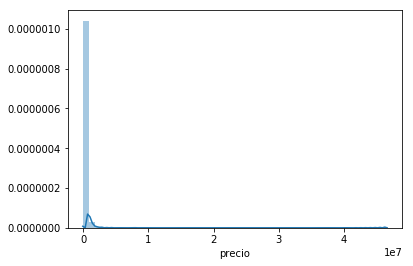

In [35]:
#
sns.distplot(df_prop['precio'][(df_prop['barrio']=='Agronomia')]);

¿En qué barrios los precios por $m^2$ son más altos? 

¿En qué barrios hay una mayor cantidad de viviendas para su venta?

¿ En qué barrios hay una mayor dispersión de precios?

¿Qué tipo de propiedad presenta los mayores precios? ¿Cuál las mayores dispersiones?

Continua realizando un análisis exploratorio del dataset...

## BONUS: Empezando con regresiones lineales...

Si se atreven, podrían empezar a probar con algunos modelos de regresión no demasiado sofisticados. Seleccionen (o construyan) su variable dependiente ($Y$) y comiencen probando con pocas variables y modelos sencillos.

Usen el estimador `LinearRegression` de submódulo `sklearn.linear_model`.

Recuerden los pasos para comenzar a trabajar con estimadores en Scikit-Learn.
    
1. Elegir una clase de modelo importando la clase de estimador apropiado de Scikit-Learn.
2. Seleccionar los hiperparámetros del modelo instanciando la clase con los valores deseados.
3. Preparar los datos en una matriz de features y un array target, como vimos previamente.
4. Ajustar el modelo a los datos invocando el método fit() de la instancia del modelo.
5. Aplicar el modelo a nuevos datos:
    * Para aprendizaje supervisado, frecuentemente predecimos labels para datos nuevos usando el método predict()
    * Para aprendizaje no supervisado, frecuentemente transformamos o inferimos propiedades de los datos usando los métodos transform() o predict()
    
¿Qué pueden decir del ajuste y la capacidad predictiva de sus modelos?

In [0]:
from sklearn.linear_model import LinearRegression